In [12]:
import mcmclib
import torch
import random
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

SEED = 123

In [13]:
golden_sample = torch.load('mcmc_samples_20000.pt')
dataset = torch.load("dataset.pt")
teams = torch.load("teams.pt")
teams_number = list(range(len(teams)))

random.seed(SEED)
k = 0.619

sample_dataset = random.sample(dataset, int(len(dataset) * k))


def custom_model(matches, n_teams):
    X = [pyro.sample(f"X{i}", dist.Normal(0, 1)) for i in range(n_teams)]

    for i, m in enumerate(matches):
        pyro.sample(f"w{i}",
                    dist.Bernoulli(logits=5*(X[m[0]]-X[m[1]])),
                    obs=torch.tensor(1.))


session = mcmclib.MCMC_Session(seed=SEED, custom_model=custom_model)

TypeError: MCMC_Session.__init__() got an unexpected keyword argument 'model'

In [ ]:
_ = session.run(sample_dataset, [5, 10, 50, 100, 200, 300], len(teams))

Sample: 100%|██████████| 320/320 [02:44,  1.95it/s, step size=1.09e+00, acc. prob=0.090]


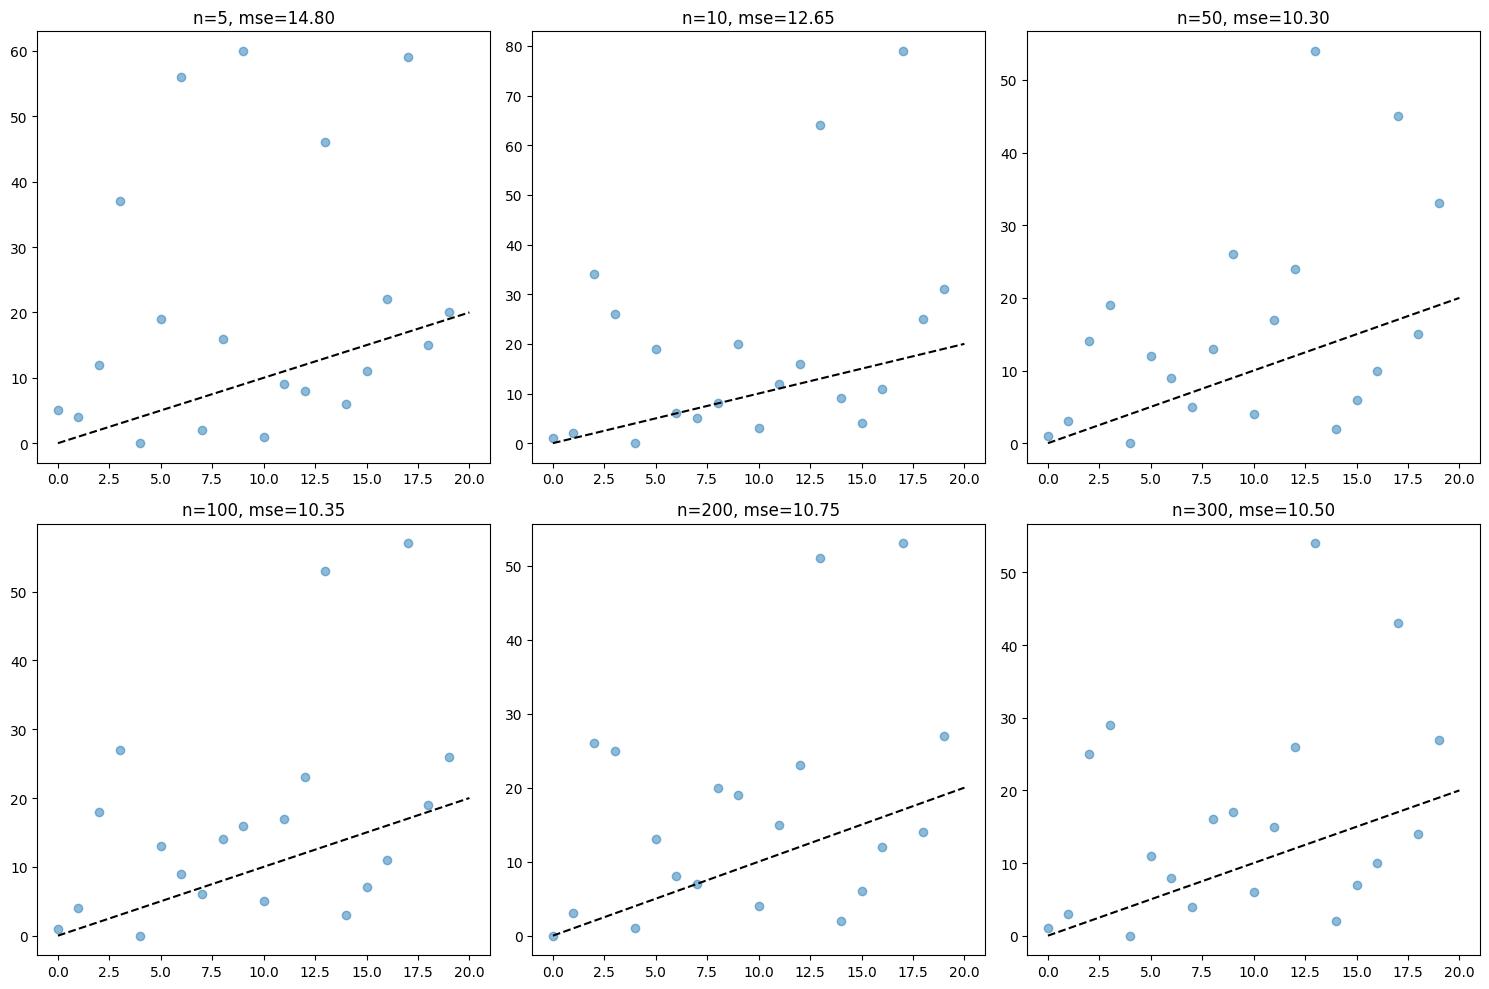

In [11]:
session.compare_top_n(golden_sample, teams_number, 20)